<a href="https://colab.research.google.com/github/amr552/Deep-Learning/blob/NLP/pre-trained%20models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Epoch 1/50
83/83 [==============================] - 198s 2s/step - loss: 0.8912 - accuracy: 0.7171 - val_loss: 0.1893 - val_accuracy: 0.9333
Epoch 2/50
83/83 [==============================] - 159s 2s/step - loss: 0.3703 - accuracy: 0.8540 - val_loss: 0.1364 - val_accuracy: 0.9667
Epoch 3/50
83/83 [==============================] - 158s 2s/step - loss: 0.3089 - accuracy: 0.8820 - val_loss: 0.0914 - val_accuracy: 0.9833
Epoch 4/50
83/83 [==============================] - 151s 2s/step - loss: 0.2293 - accuracy: 0.9145 - val_loss: 0.0899 - val_accuracy: 0.9667
Epoch 5/50
83/83 [==============================] - 153s 2s/step - loss: 0.2126 - accuracy: 0.9206 - val_loss: 0.1075 - val_accuracy: 0.9667
Epoch 6/50
83/83 [=========================

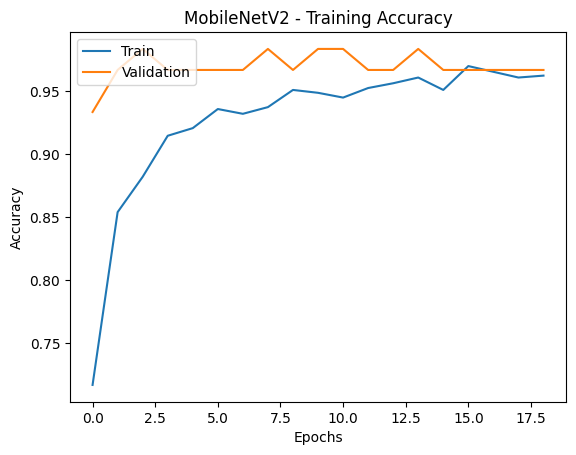

10/10 [==============================] - 14s 1s/step - loss: 0.1413 - accuracy: 0.9733
Test Accuracy: 0.9733
10/10 [==============================] - 14s 1s/step
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.21      0.22      0.21        50
     Powdery       0.22      0.20      0.21        50
        Rust       0.31      0.32      0.32        50

    accuracy                           0.25       150
   macro avg       0.25      0.25      0.25       150
weighted avg       0.25      0.25      0.25       150

Confusion Matrix:
[[11 24 15]
 [20 10 20]
 [22 12 16]]


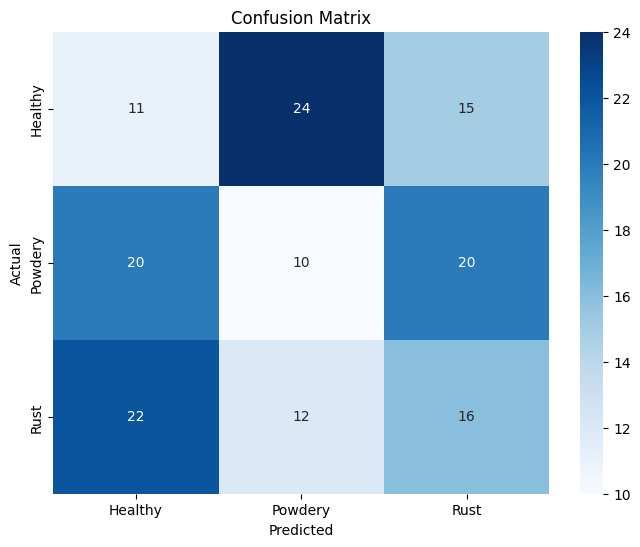

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/datasets/plant disease/savedmodels/MobileNetV2.h5


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, Dropout,AveragePooling2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set the paths to your training and test datasets

train_dir = "/content/drive/MyDrive/datasets/plant disease/Train/Train"
test_dir = "/content/drive/MyDrive/datasets/plant disease/Test/Test"
val_dir = "/content/drive/MyDrive/datasets/plant disease/Validation/Validation"
# Set the image dimensions and batch size
img_width, img_height = 224,224
batch_size = 16

# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model
base_model.trainable = False

# Add new layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjust the output layer for 3 classes
])

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with data augmentation
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

# Generate training accuracy graph
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("MobileNetV2 - Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate classification report and confusion matrix
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(report)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()




model_save_path = "/content/drive/MyDrive/datasets/plant disease/savedmodels/MobileNetV2.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Epoch 1/50
83/83 [==============================] - 329s 4s/step - loss: 1.3276 - accuracy: 0.3351 - val_loss: 1.0827 - val_accuracy: 0.4333
Epoch 2/50
83/83 [==============================] - 317s 4s/step - loss: 1.0987 - accuracy: 0.3215 - val_loss: 1.0909 - val_accuracy: 0.3333
Epoch 3/50
83/83 [==============================] - 318s 4s/step - loss: 1.0961 - accuracy: 0.3540 - val_loss: 1.0959 - val_accuracy: 0.3333
Epoch 4/50
83/83 [==============================] - 331s 4s/step - loss: 1.0977 - accuracy: 0.3502 - val_loss: 1.0832 - val_accuracy: 0.3333
Epoch 5/50
83/83 [==============================] - 330s 4s/step - loss: 1.0958 - accuracy: 0.3684 - val_loss: 1.0818 - val_accuracy: 0.4833
Epoch 6/50
83/83 [=========================

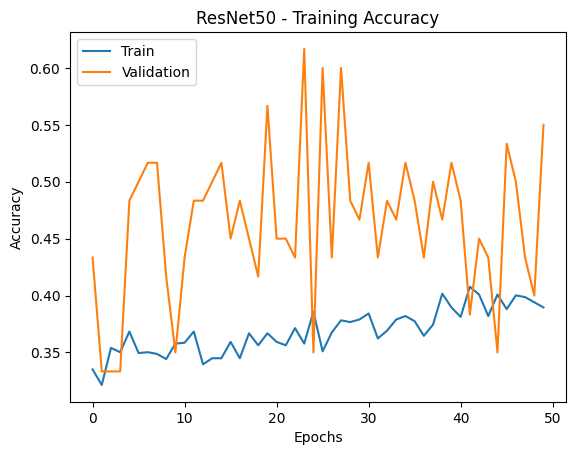

10/10 [==============================] - 33s 3s/step - loss: 1.0587 - accuracy: 0.4733
Test Accuracy: 0.4733
10/10 [==============================] - 35s 3s/step
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.36      0.66      0.46        50
     Powdery       0.34      0.40      0.37        50
        Rust       0.00      0.00      0.00        50

    accuracy                           0.35       150
   macro avg       0.23      0.35      0.28       150
weighted avg       0.23      0.35      0.28       150

Confusion Matrix:
[[33 17  0]
 [30 20  0]
 [29 21  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


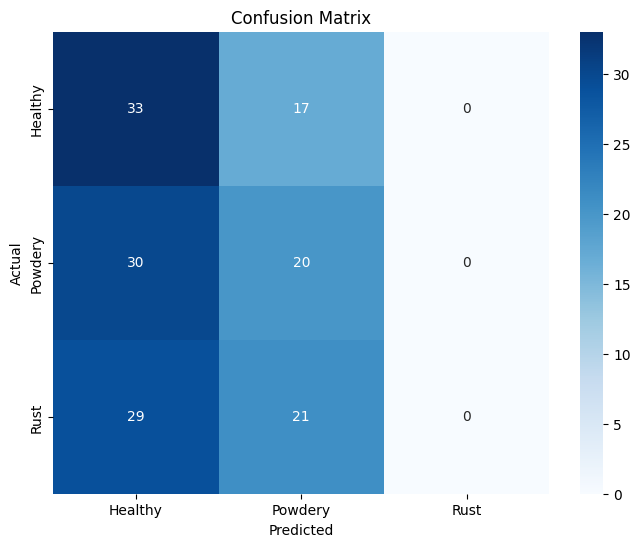

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/datasets/plant disease/savedmodels/ResNet50.h5


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Import seaborn for the heatmap
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, Dropout,AveragePooling2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set the paths to your training and test datasets

train_dir = "/content/drive/MyDrive/datasets/plant disease/Train/Train"
test_dir = "/content/drive/MyDrive/datasets/plant disease/Test/Test"
val_dir = "/content/drive/MyDrive/datasets/plant disease/Validation/Validation"
# Set the image dimensions and batch size
img_width, img_height = 224,224
batch_size = 16

# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model
base_model.trainable = False

# Add new layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjust the output layer for 3 classes
])

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with data augmentation
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

# Generate training accuracy graph
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("ResNet50 - Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate classification report and confusion matrix
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(report)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

model_save_path = "/content/drive/MyDrive/datasets/plant disease/savedmodels/ResNet50.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/25
83/83 [==============================] - 161s 2s/step - loss: 1.0171 - accuracy: 0.7307 - val_loss: 0.1129 - val_accuracy: 0.9500
Epoch 2/25
83/83 [==============================] - 148s 2s/step - loss: 0.3852 - accuracy: 0.8623 - val_loss: 0.0504 - val_accuracy: 1.0000
Epoch 3/25
83/83 [==============================] - 152s 2s/step - loss: 0.2670 - accuracy: 0.9047 - val_loss: 0.0460 - val_accuracy: 0.9833
Epoch 4/25
83/83 [==============================] - 144s 2s/step - loss: 0.2241 - accuracy: 0.9191 - val_loss: 0.0306 - val_accuracy: 1.0000
Epoch 5/25
83/83 [==============================] - 146s 2s/step - loss: 0.1986 - accuracy: 0.9297 - val_loss: 0.0317 -

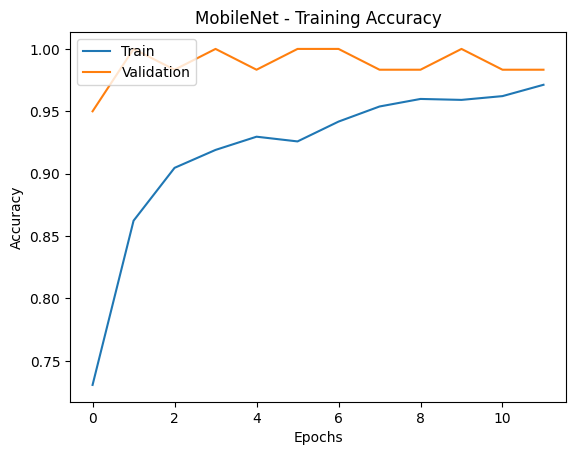

10/10 [==============================] - 14s 1s/step - loss: 0.1929 - accuracy: 0.9400
Test Accuracy: 0.9400
10/10 [==============================] - 14s 1s/step
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.26      0.28      0.27        50
     Powdery       0.39      0.36      0.37        50
        Rust       0.36      0.36      0.36        50

    accuracy                           0.33       150
   macro avg       0.34      0.33      0.33       150
weighted avg       0.34      0.33      0.33       150

Confusion Matrix:
[[14 16 20]
 [20 18 12]
 [20 12 18]]


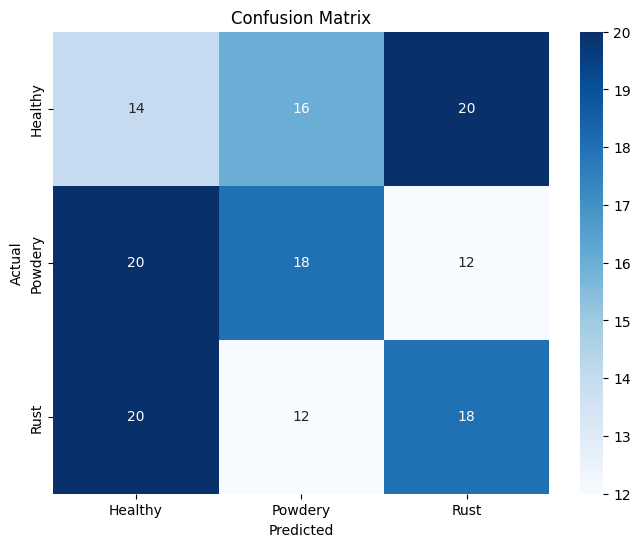

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/datasets/plant disease/savedmodels/MobileNet.h5


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, Dropout,AveragePooling2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set the paths to your training and test datasets

train_dir = "/content/drive/MyDrive/datasets/plant disease/Train/Train"
test_dir = "/content/drive/MyDrive/datasets/plant disease/Test/Test"
val_dir = "/content/drive/MyDrive/datasets/plant disease/Validation/Validation"
# Set the image dimensions and batch size
img_width, img_height = 224,224
batch_size = 16

# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model
base_model.trainable = False

# Add new layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjust the output layer for 3 classes
])

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with data augmentation
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

# Generate training accuracy graph
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("MobileNet - Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate classification report and confusion matrix
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(report)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


model_save_path = "/content/drive/MyDrive/datasets/plant disease/savedmodels/MobileNet.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
258076736/258076736 [==============================] - 3s 0us/step
Epoch 1/20
83/83 [==============================] - 790s 9s/step - loss: 1.2120 - accuracy: 0.3442 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 2/20
83/83 [==============================] - 734s 9s/step - loss: 1.0986 - accuracy: 0.3457 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 3/20
83/83 [==============================] - 733s 9s/step - loss: 1.0991 - accuracy: 0.3457 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/20
83/83 [==============================] - 724s 9s/step - loss: 1.0986 - accuracy: 0.3464 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 5/20
83/83 [==============================] - 760s 9s/step - loss: 1.0986 - accuracy: 0.3464 - val_loss: 1.0986

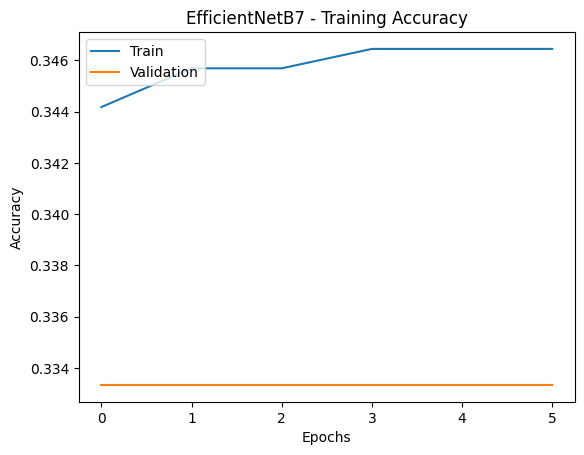

10/10 [==============================] - 75s 7s/step - loss: 1.0986 - accuracy: 0.3333
Test Accuracy: 0.3333
10/10 [==============================] - 81s 7s/step
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.33      1.00      0.50        50
     Powdery       0.00      0.00      0.00        50
        Rust       0.00      0.00      0.00        50

    accuracy                           0.33       150
   macro avg       0.11      0.33      0.17       150
weighted avg       0.11      0.33      0.17       150

Confusion Matrix:
[[50  0  0]
 [50  0  0]
 [50  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


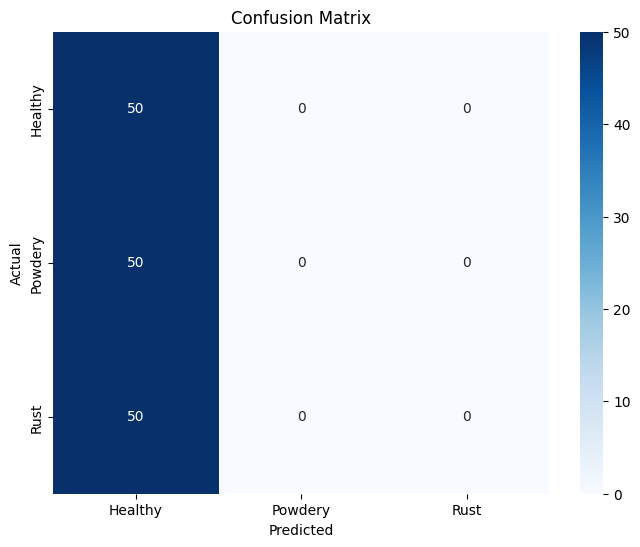

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/datasets/plant disease/savedmodels/EfficientNetB7.h5


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, Dropout,AveragePooling2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set the paths to your training and test datasets

train_dir = "/content/drive/MyDrive/datasets/plant disease/Train/Train"
test_dir = "/content/drive/MyDrive/datasets/plant disease/Test/Test"
val_dir = "/content/drive/MyDrive/datasets/plant disease/Validation/Validation"
# Set the image dimensions and batch size
img_width, img_height = 224,224
batch_size = 16

# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = EfficientNetB7(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model
base_model.trainable = False

# Add new layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjust the output layer for 3 classes
])

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with data augmentation
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

# Generate training accuracy graph
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("EfficientNetB7 - Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate classification report and confusion matrix
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(report)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


model_save_path = "/content/drive/MyDrive/datasets/plant disease/savedmodels/EfficientNetB7.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
234698864/234698864 [==============================] - 2s 0us/step
Epoch 1/20
83/83 [==============================] - 715s 8s/step - loss: 1.1830 - accuracy: 0.3222 - val_loss: 1.0944 - val_accuracy: 0.3667
Epoch 2/20
83/83 [==============================] - 687s 8s/step - loss: 1.1002 - accuracy: 0.3238 - val_loss: 1.0944 - val_accuracy: 0.3833
Epoch 3/20
83/83 [==============================] - 680s 8s/step - loss: 1.0981 - accuracy: 0.3434 - val_loss: 1.0992 - val_accuracy: 0.3500
Epoch 4/20
83/83 [==============================] - 695s 8s/step - loss: 1.0987 - accuracy: 0.3162 - val_loss: 1.0920 - val_accuracy: 0.3333
Epoch 5/20
83/83 [==============================] - 678s 8s/step - loss: 1.0980 - accuracy: 0.3185 - val_loss: 1.0991

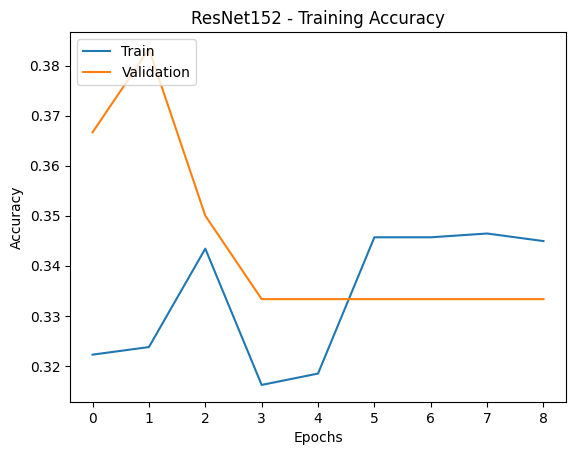

10/10 [==============================] - 71s 7s/step - loss: 1.0983 - accuracy: 0.3333
Test Accuracy: 0.3333
10/10 [==============================] - 75s 7s/step
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.33      1.00      0.50        50
     Powdery       0.00      0.00      0.00        50
        Rust       0.00      0.00      0.00        50

    accuracy                           0.33       150
   macro avg       0.11      0.33      0.17       150
weighted avg       0.11      0.33      0.17       150

Confusion Matrix:
[[50  0  0]
 [50  0  0]
 [50  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


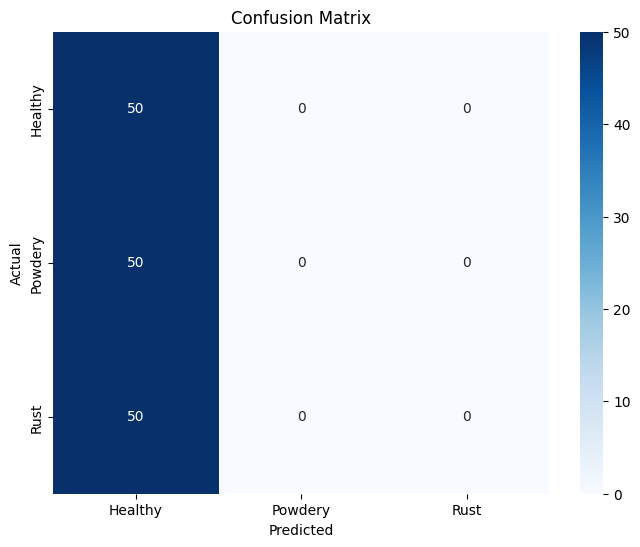

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/datasets/plant disease/savedmodels/ResNet152.h5


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, Dropout,AveragePooling2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set the paths to your training and test datasets

train_dir = "/content/drive/MyDrive/datasets/plant disease/Train/Train"
test_dir = "/content/drive/MyDrive/datasets/plant disease/Test/Test"
val_dir = "/content/drive/MyDrive/datasets/plant disease/Validation/Validation"
# Set the image dimensions and batch size
img_width, img_height = 224,224
batch_size = 16

# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = ResNet152(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model
base_model.trainable = False

# Add new layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjust the output layer for 3 classes
])

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with data augmentation
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

# Generate training accuracy graph
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("ResNet152 - Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate classification report and confusion matrix
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(report)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


model_save_path = "/content/drive/MyDrive/datasets/plant disease/savedmodels/ResNet152.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')